<a href="https://colab.research.google.com/github/jman4162/Phased-Array-Antenna-Model/blob/main/Phased_Array_Antennas_Computing_Radiation_Patterns_Using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phased Array Antennas: Computing Radiation Patterns Using Python

Name: John Hodge (jah70@vt.edu)

Date: 04/14/24

License: MIT License

# 1) Introduction

In this tutorial, we delve into the mathematics and computational techniques behind phased array antennas—a pivotal technology that has evolved significantly over the past few decades. From their inception in the mid-20th century to their critical role in modern communications and radar systems, phased array antennas have been at the forefront of technological advancements in both civilian and defense sectors.

Understanding the radiation patterns of these antennas is crucial for optimizing their performance in various applications such as satellite communications, weather monitoring, and the rapidly expanding field of 5G telecommunications. This tutorial will equip you with the ability to compute and visualize these patterns using Python, leveraging libraries such as NumPy and Matplotlib for effective simulation and analysis.

**Objective**: By the end of this tutorial, you will have a clear understanding of the principles of phased array antennas and be able to compute and visualize their radiation patterns using Fourier transform techniques in Python.

**Structure**: We will start with a brief review of the theoretical concepts underlying phased array systems, followed by a step-by-step guide on setting up your coding environment. The main sections will include detailed explanations and code examples for calculating and plotting the radiation patterns.

**Prerequisites**: Readers should have a basic understanding of electromagnetism and Python programming. Familiarity with libraries such as NumPy and Matplotlib is recommended, though not mandatory, as the tutorial will provide the necessary guidance on using these tools.


## 1.1) What is a Phased Array Antenna?

Phased array antennas represent a sophisticated class of antenna systems that harness the power of multiple individual antennas working together to direct their beams without physical movement. This is achieved through the precise control of the phase of the signal at each antenna element, enabling the beam to be steered electronically across a wide area. Such capabilities make phased array antennas a cornerstone technology in a variety of critical applications, ranging from radar systems used in aerospace and defense to advanced communication networks like those found in satellite and 5G technology.

The concept of a phased array is rooted in the principle of constructive and destructive interference. By adjusting the phase and sometimes the amplitude of the signal emitted from each antenna element, the overall beam can be shaped and directed to achieve desired coverage and performance. This ability to dynamically alter the beam pattern in real time offers substantial improvements over traditional mechanically steered antennas, including faster target acquisition and tracking, greater system flexibility, and reduced mechanical complexity.

Moreover, phased array systems are pivotal in environments requiring rapid, reliable, and precise antenna operations. Their versatility and efficiency have led to widespread adoption in both military and civilian sectors, where they are used not only in radar but also in telecommunications infrastructure, broadcasting, and space exploration.

This introduction to phased array antennas lays the groundwork for exploring their technical mechanisms, computational modeling, and the vast array of applications they support, which are transforming the landscape of modern technology.



# 2) Setup the coding environment

In [73]:
!pip install numpy matplotlib scipy seaborn requests

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from IPython.display import SVG
from scipy.constants import pi, c

# 3) Define antenna parameters

To compute the radiation pattern of a phased array antenna using a Fourier transform over a specified set of theta ($\theta$) and phi ($\phi$) angles, and for given beam steering angles in theta and phi, you can follow the steps outlined below. This method leverages the FFT to efficiently compute the angular response of the array by exploiting the periodicity and symmetry properties of the Fourier transform.

### Define the Geometry and Elements of the Array
- **Element positions**: Determine the Cartesian or polar coordinates of each antenna element in the phased array. Let's denote these positions as ($x_n, y_n$) for each element \($n$\).

### Determine the Wavenumber
- **Wavenumber \( $k$ \)**: The wavenumber is defined as $k = \frac{2\pi}{\lambda} $, where \($\lambda$\) is the wavelength of the radiated wave.

In [75]:
# Antenna parameters
Nx = 16 # number of elements in the x-direction
Ny = 8 # number of elements in the y-direction
dx = 0.5  # spacing between elements in the x-direction (in wavelengths)
dy = dx  # spacing between elements in the y-direction (in wavelengths)
freq_GHz = 3.0 # frequency (GHz)

system_losses_dB = 0
ep_max_gain_dBi = 0 # Max gain of the element pattern (EP)
cos_factor_theta = 1.2 # Raised cosine factor of the EP in theta
cos_factor_phi = 1.2 # Raised cosine factor of the EP in phi

# Derived antenna parameters
f = 1e9 * freq_GHz  # convert frequency to Hz
lambda_ = c / f  # wavelength (meters)
k = 2 * pi / lambda_ # wave vector

# Express grid spacing in meters
dx_m = dx * lambda_
dy_m = dy * lambda_

# Compute approximate aperture directivity
aperture_area = Nx * Ny * dx_m * dy_m
D = 4 * pi * aperture_area / lambda_**2
D_dBi = 10 * np.log10(D)

# Estimate 3 dB beamwidth (BW) at broadside for the array aperature
beamwidth_broadside_x = 0.886 * lambda_ / (Nx * dx_m)
beamwidth_broadside_y = 0.886 * lambda_ / (Ny * dy_m)

# Number of Array Elements
num_elements = Nx * Ny

In [76]:
# Print derived antenna parameters
print('Estimated aperture directivity (dBi):', np.round(D_dBi, 1))
print('Estimated 3 dB beamwidth at broadside (x):', np.round(beamwidth_broadside_x * 180 / pi, 1), 'degrees')
print('Estimated 3 dB beamwidth at broadside (y):', np.round(beamwidth_broadside_y * 180 / pi, 1), 'degrees')
print('Aperture dimensions (x):', np.round(Nx*dx_m, 2), 'meters')
print('Aperture dimensions (y):', np.round(Ny*dy_m, 2), 'meters')
print('Apreture area:', np.round(aperture_area, 2), 'm^2')
print('Total number of antenna elements:', num_elements)

Estimated aperture directivity (dBi): 26.0
Estimated 3 dB beamwidth at broadside (x): 6.3 degrees
Estimated 3 dB beamwidth at broadside (y): 12.7 degrees
Aperture dimensions (x): 0.8 meters
Aperture dimensions (y): 0.4 meters
Apreture area: 0.32 m^2
Total number of antenna elements: 128


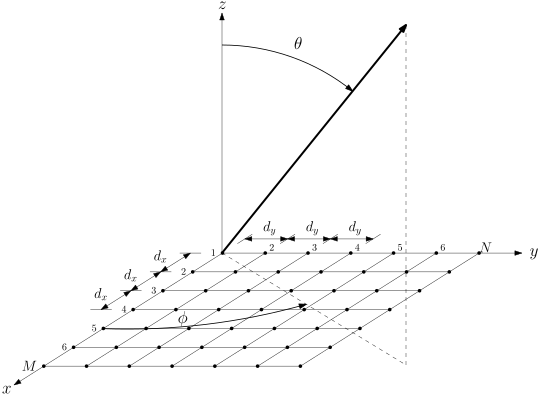

A depiction of a rectangular phased array antenna with the assumed coordinates.


In [77]:
url = 'https://upload.wikimedia.org/wikipedia/commons/e/e3/Array_frame.svg'
svg_string = requests.get(url).content
# Add style attribute with white background color
svg_string = svg_string.decode().replace('<svg>', '<svg style="background-color:white" ')
display(SVG(svg_string))

print('A depiction of a rectangular phased array antenna with the assumed coordinates.')

### **How does the spacing between elements affect the radiation pattern?**

The spacing \($d$ \) between elements is critical as it influences the array's ability to resolve different directions and can cause phenomena like grating lobes (unwanted peaks in the radiation pattern) if too large relative to the wavelength. The general rule is to keep the spacing less than or equal to half the wavelength ($\lambda/2$) to avoid these issues.

These questions and their answers lay the foundation for understanding the interplay of geometry, wave physics, and signal processing in the design and operation of phased array antennas. This knowledge is crucial for optimizing antenna designs and achieving desired beamforming capabilities.

In [78]:
# Define element locations

# Element positions in x and y directions (assuming origin is at the center)
x = np.arange(Nx) - (Nx - 1) / 2
y = np.arange(Ny) - (Ny - 1) / 2

x = x * dx_m
y = y * dy_m

# Define mesh grid of element locations
X, Y = np.meshgrid(x, y)

# Transform X and Y into 1-D vectors
X_vec = X.reshape(-1)
Y_vec = Y.reshape(-1)

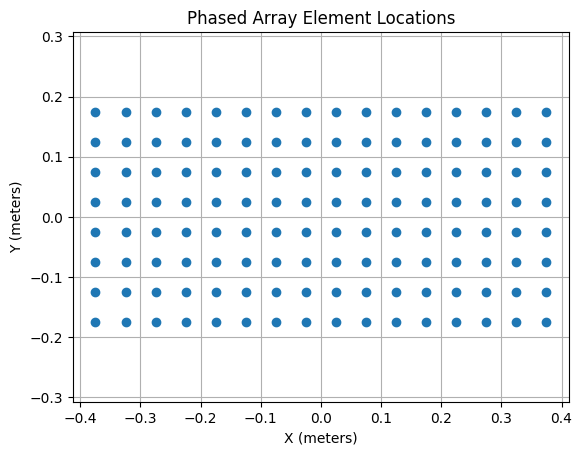

In [79]:
# Plot the element locations X and Y using a scatter plot.
plt.figure()
plt.scatter(X, Y)
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.title('Phased Array Element Locations')
plt.grid(True)
plt.axis('equal')
plt.show()

# 4) Compute Radiation Pattern Beam Steering Vector

## Calculate Steering Vector
- **Steering angles \($\theta_0$\) and \($\phi_0$\)**: Define the steering angles for the beam. These are the directions in which the main beam of the antenna should point.
- **Steering vector \( $\mathbf{a}(\theta_0, \phi_0) $ \)**: Compute the phase shifts required for each antenna element to steer the beam towards \( $\theta_0$, $\phi_0$ \). The phase shift for an element at position \($x_n$, $y_n$\) is given by $ e^{-j k (x_n \sin\theta_0 \cos\phi_0 + y_n \sin\theta_0 \sin\phi_0)} $.

## Excitation Amplitudes
- Define the excitation amplitudes \($ \mathbf{w}$ \) for each element, which could be uniform or follow some weighting scheme to shape the beam or control sidelobe levels.

## How does Beam Steering work mathematically?

Beam steering is achieved by introducing a specific phase shift to each antenna element in the array. The phase shift \($\phi_{x,y}$ \) for each element positioned at coordinates (x, y) in the array can be described mathematically as:

$ \phi_{x,y} = e^{j \cdot (k_x x + k_y y)} $

where:
- $ k_x = \frac{2\pi}{\lambda} \sin(\theta_0) \cos(\phi_0) $
- $ k_y = \frac{2\pi}{\lambda} \sin(\theta_0) \sin(\phi_0) $
- $ \theta_0 $ and $ \phi_0 $ are the steering angles in the elevation and azimuth directions, respectively.
- $ \lambda $ is the wavelength of the signal.

The values $ k_x $ and $ k_y $ represent the wave numbers in the x and y directions, which relate to how the wave propagates through space.

In [80]:
theta0 = 30 # Beam steering angle in theta (degrees)
phi0 = 45 # 0Beam steering angle in phi (degrees)

In [81]:
def steering_vector(k, xv, yv, theta_deg, phi_deg):

    theta = np.radians(theta_deg)
    phi = np.radians(phi_deg)

    kx = k * np.sin(theta) * np.cos(phi)
    ky = k * np.sin(theta) * np.sin(phi)

    # Calculate the phase shift for each element
    phase_weights = np.exp(1j * (kx * xv + ky * yv))

    return phase_weights

In [82]:
phase_weights = steering_vector(k=k,
                                xv=X,
                                yv=Y,
                                theta_deg=theta0,
                                phi_deg=phi0)

phase_shift_rad = np.angle(phase_weights)
phase_shift_deg = np.degrees(phase_shift_rad)

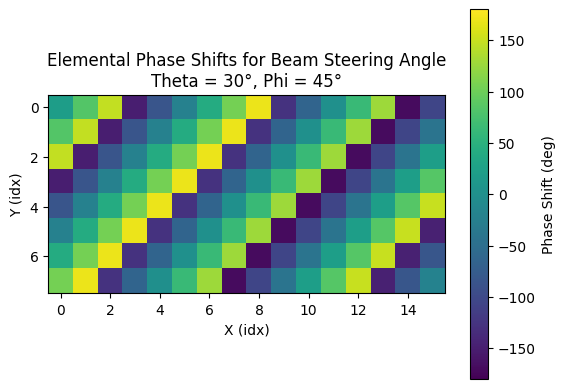

In [83]:
plt.figure()
plt.imshow(phase_shift_deg, clim=(-180, 180))
plt.colorbar(label='Phase Shift (deg)')
plt.title('Elemental Phase Shifts for Beam Steering Angle\nTheta = {}°, Phi = {}°'.format(theta0, phi0))
plt.xlabel('X (idx)')
plt.ylabel('Y (idx)')
plt.show()

## 5) Compute Radiation Pattern

## 5.1) Define a single radiatior's average element pattern (EP) using cosine functions

### Cosine Antenna Element Response

The object returns the field response (also called field pattern) of the cosine antenna element.

#### Response Function

The field response function, $ f(\text{az}, \text{el}) $, for the cosine antenna element is defined as:

$f(\text{az}, \text{el}) = \cos^m(\text{az}) \cos^n(\text{el})$

where:
- $ \text{az} $ is the azimuth angle.
- $ \text{el} $ is the elevation angle.
- $ m $ and $ n $ are exponents which are real numbers greater than or equal to zero.

### Characteristics of the Response

The response is defined for azimuth and elevation angles between $ -90^\circ $ and $ 90^\circ $, inclusive, and is always positive. There is no response at the backside of a cosine antenna.

The cosine response pattern achieves a maximum value of 1 at $ 0^\circ $ azimuth and $ 0^\circ $ elevation. Larger exponent values narrow the response pattern of the element and increase the directivity.


Ref: [Cosine Antenna Element
](https://www.mathworks.com/help/phased/ug/cosine-antenna-element.html)



In [84]:
def dBi_to_linear(dBi):
  """Converts dBi to linear scale."""
  return 10**(dBi / 10)

In [85]:
def antenna_element_pattern(theta: np.ndarray, phi: np.ndarray,
                             cos_factor_theta: float = 1.0, cos_factor_phi: float = 1.0,
                             max_gain_dBi: float = 0.0) -> np.ndarray:
  """
  Calculates the radiation pattern of a single antenna element using a raised cosine model.

  Args:
    theta: Elevation angles in radians (numpy.ndarray).
    phi: Azimuth angles in radians (numpy.ndarray).
    cos_factor_theta: Cosine power factor for theta (float, default=1.0).
    cos_factor_phi: Cosine power factor for phi (float, default=1.0).
    max_gain_dBi: Maximum gain of the element pattern in dBi (float, default=0.0).

  Returns:
    A numpy array containing the element pattern values in linear scale.
  """

  # Convert max gain from dBi to linear scale
  max_gain = dBi_to_linear(max_gain_dBi)

  # Calculate the radiation pattern
  pattern = max_gain * np.cos(theta) ** cos_factor_theta * np.cos(phi) ** cos_factor_phi

  return pattern

(180, 180)


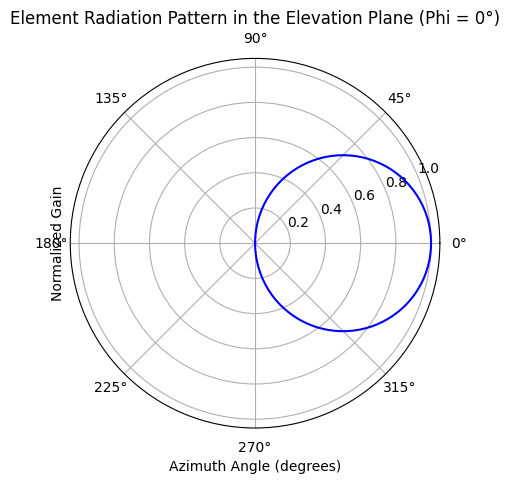

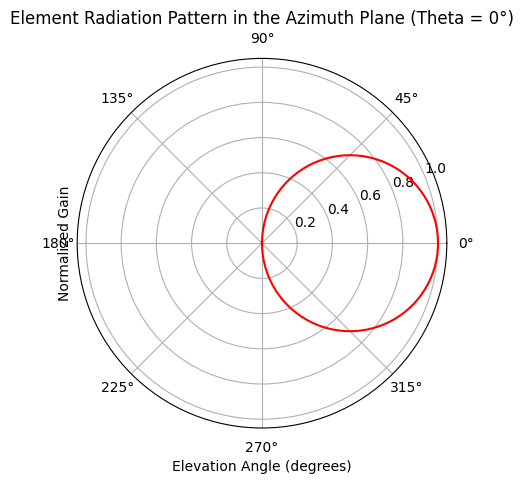

In [86]:
def test_antenna_element_pattern():

  theta = np.radians(np.linspace(-90, 90, 180))
  phi = np.radians(np.linspace(-90, 90, 180))

  THETA, PHI = np.meshgrid(theta, phi)
  pattern = antenna_element_pattern(THETA, PHI)

  print(pattern.shape)

  # Plot the radiation pattern in the elevation plane (phi = 0)
  plt.figure()
  plt.polar(phi, pattern[90], 'b-')
  plt.title('Element Radiation Pattern in the Elevation Plane (Phi = 0°)')
  plt.ylabel('Normalized Gain')
  plt.xlabel('Azimuth Angle (degrees)')
  plt.show()

  # Plot the radiation pattern in the azimuth plane (theta = 0)
  plt.figure()
  plt.polar(theta, pattern[90], 'r-')
  plt.title('Element Radiation Pattern in the Azimuth Plane (Theta = 0°)')
  plt.ylabel('Normalized Gain')
  plt.xlabel('Elevation Angle (degrees)')
  plt.show()

test_antenna_element_pattern()

## 5.2) Azimuth and Elevation (Az/El) Coordinates

Ref: [phitheta2azel](https://www.mathworks.com/help/phased/ref/phitheta2azel.html)

Convert az/el coordinates to $\theta$/$\phi$ coordinates, and vice versa:

1. $\sin(el) = \sin(\phi) \sin(\theta)$
2. $\tan(az) = \cos(\phi) \tan(\theta)$
3. $\cos(\theta) = \cos(el) \cos(az)$
4. $\tan(\phi) = \frac{\tan(el)}{\sin(az)}$


A depiction of azimuth and elevation coordinates.


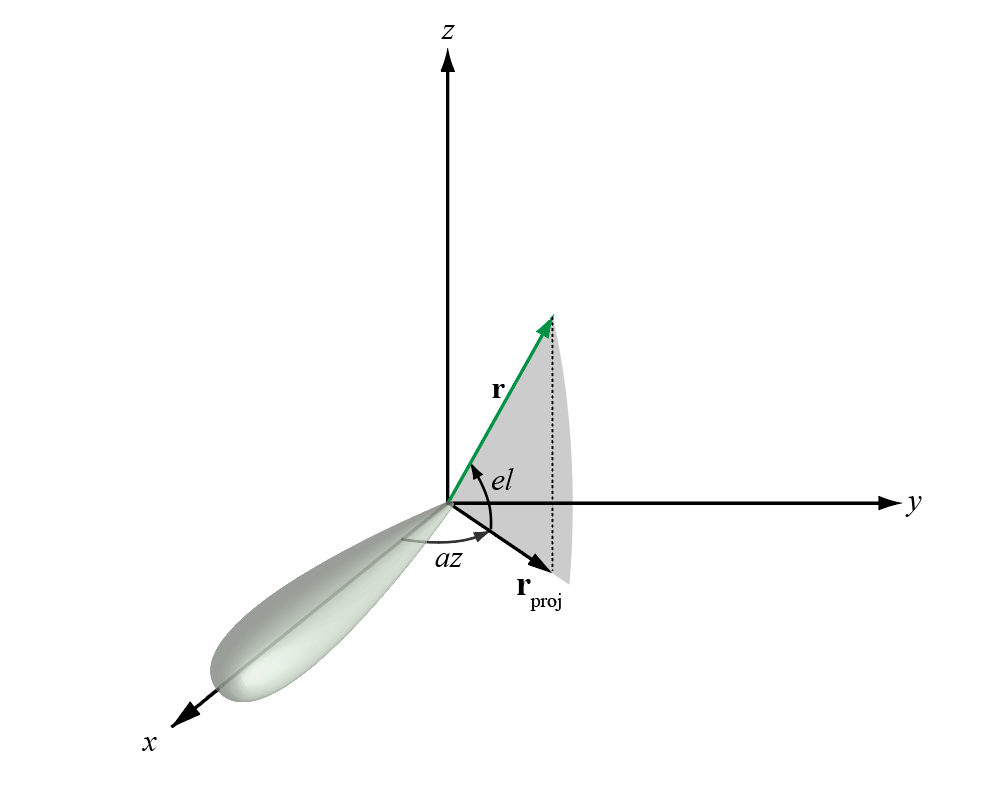

In [87]:
from IPython.display import Image

print('A depiction of azimuth and elevation coordinates.')
url = 'https://www.mathworks.com/help/phased/ref/lobes.azel02573280e2ae1a2c6d47a352ed6aedc0.png'
Image(url, width=400)

In [88]:
def azel_to_thetaphi(az, el):
    """ Az-El to Theta-Phi conversion.

    Args:
        az (float or np.array): Azimuth angle, in radians
        el (float or np.array): Elevation angle, in radians

    Returns:
      (theta, phi): Tuple of corresponding (theta, phi) angles, in radians
    """

    cos_theta = np.cos(el) * np.cos(az)
    # tan_phi = np.where(np.abs(np.sin(az)) < 1e-6, 0, np.tan(el) / np.sin(az)) # Avoid the divide by zero

    theta     = np.arccos(cos_theta)
    phi       = np.arctan2(np.tan(el), np.sin(az))
    phi = (phi + 2 * np.pi) % (2 * np.pi)

    return theta, phi

In [89]:
def thetaphi_to_azel(theta, phi):
    """ Az-El to Theta-Phi conversion.

    Args:
        theta (float or np.array): Theta angle, in radians
        phi (float or np.array): Phi angle, in radians

    Returns:
      (az, el): Tuple of corresponding (azimuth, elevation) angles, in radians
    """
    sin_el = np.sin(phi) * np.sin(theta)
    tan_az = np.cos(phi) * np.tan(theta)
    el = np.arcsin(sin_el)
    az = np.arctan(tan_az)

    return az, el

Define the observation angles to compute the radiation pattern over.

In [90]:
# Define observation angles
theta_deg = np.linspace(-90, 90, 181)
phi_deg = np.linspace(-90, 90, 181)

theta = np.deg2rad(theta_deg)
phi = np.deg2rad(phi_deg)

# Make a meshgrid of theta and phi
THETA, PHI = np.meshgrid(theta, phi)

# Convert to azimuth and elevation
AZ, EL = thetaphi_to_azel(THETA, PHI)

## 5.3) Define the array factor (AF)

### What is the Array Factor and why is it important?

The Array Factor (AF) is a function that describes the amplitude and phase characteristics of the radiation pattern produced by an array. It is determined by the geometric configuration of the array and the phasing of the individual elements. Mathematically, it is the Fourier transform of the array's spatial amplitude and phase distribution. In the context of phased arrays, AF helps in predicting how the beam can be steered and shaped by adjusting the phases of individual elements.

### Construct the Array Factor
- **Array factor**: For each potential direction \($\theta$, $\phi$\) in your angular grid, calculate the array factor $ AF(\theta, \phi) $ using:
  
  $
  AF(\theta, \phi) = \sum_{n=1}^N w_n e^{-j k (x_n \sin\theta \cos\phi + y_n \sin\theta \sin\phi)}
  $
  where \($N$\) is the number of elements, and \( $w_n$ \) is the amplitude of the nth element.

In [91]:
def AF(theta, phi, x, y, w, k):
  """
  Calculates the array factor for a given set of angles, coordinates, weights, and wave number.

  Args:
    theta: Elevation angle in radians.
    phi: Azimuth angle in radians.
    x: X-coordinates of the antenna elements.
    y: Y-coordinates of the antenna elements.
    w: Complex weights of the antenna elements.
    k: Wave number.

  Returns:
    The array factor as a complex number.
  """

  N = len(x)  # Number of antenna elements

  # Calculate the phase shift for each antenna element
  phase_shift = -1j * k * (x * np.sin(theta) * np.cos(phi) + y * np.sin(theta) * np.sin(phi))

  # Reshape the complex weights into a 1-D vector
  w_vec = w.reshape(-1)

  # Multiply the weights by the phase shift and sum them up
  AF = np.sum(w_vec * np.exp(phase_shift))

  return AF

In [92]:
array_factor = AF(theta[0], phi[0], x=X_vec, y=Y_vec, w=phase_weights, k=k)

In [93]:
# Compute element pattern over all THETA, PHI angles
element_pattern = antenna_element_pattern(THETA, PHI,
                                          cos_factor_theta,
                                          cos_factor_phi,
                                          max_gain_dBi=ep_max_gain_dBi)

print('Element Pattern Shape:', element_pattern.shape)

Element Pattern Shape: (181, 181)


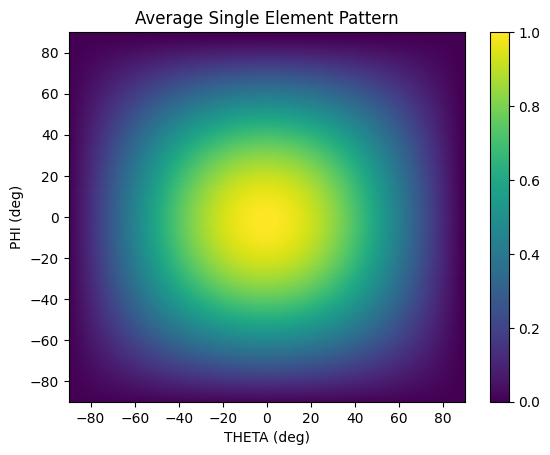

In [94]:
# Make an interpolated scatter plot using THETA, PHI, and element_pattern with color shading based on element_pattern magnitude

# Create the scatter plot
plt.figure()
plt.scatter(np.degrees(THETA), np.degrees(PHI), c=abs(abs(element_pattern)), cmap='viridis')
plt.colorbar()

# Add labels and title
plt.xlabel('THETA (deg)')
plt.ylabel('PHI (deg)')
plt.title('Average Single Element Pattern')
plt.xlim([-90, 90])
plt.ylim([-90, 90])

# Show the plot
plt.show()


In [95]:
def wrap_angle(angle):
  """
  Wraps an angle value between 0 and 2 pi.

  Args:
    angle: The angle value in radians.

  Returns:
    The wrapped angle value between 0 and 2 pi.
  """

  return angle % (2 * np.pi)


In [96]:
def test_wrap_angle():
  angle_in_radians = 10  # Example angle
  wrapped_angle = wrap_angle(angle_in_radians)
  print(f"Wrapped angle: {np.round(wrapped_angle, 2)} radians")

test_wrap_angle()

Wrapped angle: 3.72 radians


Loop over azimuth and elevation and compute the array factor at each angle.

In [97]:
# Calculate the array factor for each angle
array_factor = np.zeros((len(theta), len(phi)), dtype=complex)

for i, thi in enumerate(theta):
  for j, phj in enumerate(phi):
    array_factor[i, j] = element_pattern[i, j] * AF(thi, phj, x=X_vec, y=Y_vec, w=phase_weights, k=k)

array_factor_dB = 10 * np.log10(abs(array_factor))

# Normalize array_factor_dB
array_factor_dB_norm = array_factor_dB - np.max(array_factor_dB)

## 5.4) Convert the normalized array factor to antenna array gain.

In [98]:
# Normalize array_factor_dB
array_gain_dBi = D_dBi - system_losses_dB + array_factor_dB_norm

# 6) Analyze Results and Visualization

- The magnitude squared of the array factor result represents the power pattern of the antenna as a function of angle. The main lobe will align with the steering angle \($\theta_0$, $\phi_0$\), and the sidelobes and other characteristics of the pattern can be analyzed from this data.

- It is often useful to visualize the radiation pattern using polar plots or 3D surface plots to better understand the beam shape, sidelobe levels, and directionality of the antenna array.

In [99]:
# If a value in power_pattern is less than a minimum threshold, set it to the minimum treshold for visualization purposes
min_thres = np.max(array_factor_dB) - 50
array_factor_plot_dB = array_factor_dB.clip(min=min_thres)

min_thres = np.max(array_gain_dBi) - 50
array_gain_plot_dBi = array_gain_dBi.clip(min=min_thres)

## 6.1) Radiation pattern heatmap at the specified beam steer angle

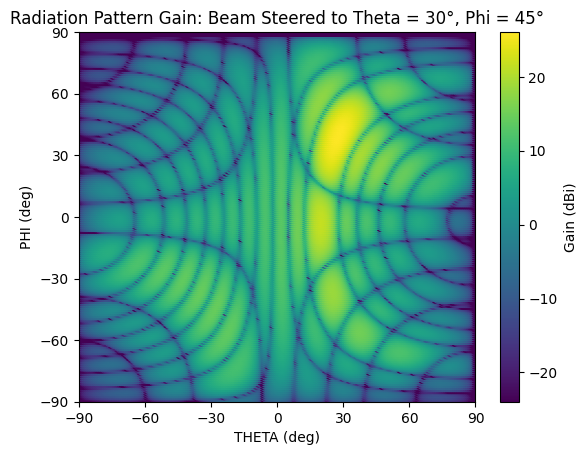

In [100]:
# Create the scatter plot
plt.figure()
plt.scatter(np.degrees(THETA), np.degrees(PHI), c=array_gain_plot_dBi.T, cmap='viridis')
plt.colorbar(label='Gain (dBi)')

# Add labels and title
plt.title(f'Radiation Pattern Gain: Beam Steered to Theta = {theta0}°, Phi = {phi0}°')
plt.xlabel('THETA (deg)')
plt.ylabel('PHI (deg)')
plt.xlim([np.min(theta_deg), np.max(theta_deg)])
plt.ylim([np.min(phi_deg), np.max(phi_deg)])
plt.xticks(np.arange(phi_deg[0], phi_deg[-1]+1, 30))
plt.yticks(np.arange(theta_deg[0], theta_deg[-1]+1, 30))

# Show the plot
plt.show()

## 6.2) Plot radiation pattern cuts

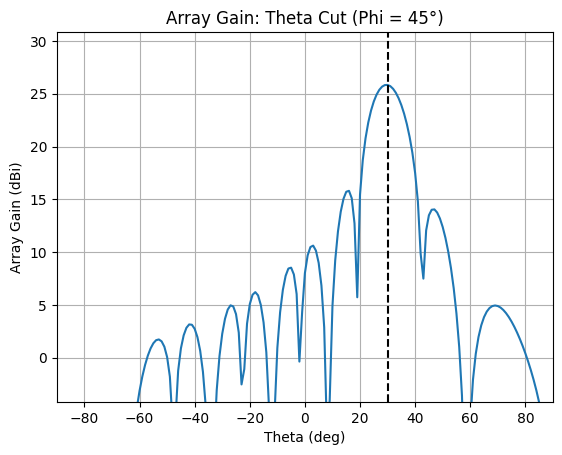

In [101]:
# For array_factor_plot_dB, plot the theta and phi radiation pattern cuts where the other variable are the steer angles, respectively
thres_dB = 30

# Find index where phi_deg and theta_deg are the steer angles, respectively
phi_zero_index = np.where(phi_deg == phi0)[0][0]
theta_zero_index = np.where(theta_deg == theta0)[0][0]

# Find the peak value in the data
peak_value_theta = np.max(array_gain_plot_dBi[:, phi_zero_index])
peak_value_phi = np.max(array_gain_plot_dBi[theta_zero_index, :])

# Set the lower y-axis limit to 30 dB below the peak
if np.max(array_gain_plot_dBi[:, phi_zero_index]) - np.min(array_gain_plot_dBi[:, phi_zero_index]) > thres_dB:
  lower_limit_theta = peak_value_theta - thres_dB

if np.max(array_gain_plot_dBi[theta_zero_index, :]) - np.min(array_gain_plot_dBi[theta_zero_index, :]) > thres_dB:
  lower_limit_phi = peak_value_phi - thres_dB

# Plot the theta cut (phi = 0)
plt.figure()
plt.plot(theta_deg, array_gain_plot_dBi[:, phi_zero_index], label='Array Gain')
plt.xlabel('Theta (deg)')
plt.ylabel('Array Gain (dBi)')
plt.title('Array Gain: Theta Cut (Phi = ' + str(phi0) + '°)')
plt.grid(True)
plt.ylim(lower_limit_theta, peak_value_theta+5)
plt.xlim([np.min(theta_deg), np.max(theta_deg)])
plt.axvline(x=theta0, color='black', linestyle='--', label='Steer Angle (Theta)')
plt.show()

# # Plot the phi cut (theta = 90)
# plt.figure()
# plt.plot(phi_deg, array_factor_plot_dB[theta_zero_index, :])
# plt.xlabel('Phi (deg)')
# plt.ylabel('Magnitude (dB)')
# plt.title('Phi Cut (Theta = 90°)')
# plt.grid(True)
# # plt.ylim(lower_limit_phi, peak_value_phi+5)
# plt.show()

## 6.3) Plot radiaiton pattern as a polar plot

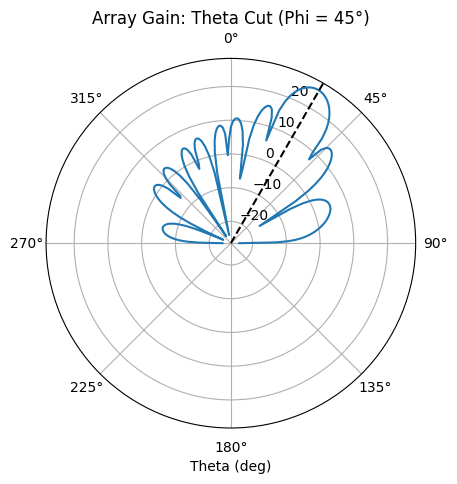

In [102]:
# Make the theta cut (phi = 0) a polar plot
plt.figure()
ax = plt.subplot(111, projection='polar')
ax.plot(theta, array_gain_plot_dBi[:, phi_zero_index], label='Phi=0')
ax.axvline(x=np.radians(theta0), color='black', linestyle='--', label='Steer Angle (Theta)')
ax.set_xlabel('Theta (deg)')
ax.set_title('Array Gain: Theta Cut (Phi = ' + str(phi0) + '°)')
ax.grid(True)
ax.set_theta_zero_location('N')  # Sets the zero of the theta location to North
ax.set_theta_direction(-1)  # Sets the theta direction to clockwise
plt.show()

# 7) Future Code Improvements

## 7.1) Vectorize array factor and use FFT radiation pattern computations for efficiency

### 7.1.1) Why use FFT to compute the Array Factor?

The FFT (Fast Fourier Transform) is used to compute the Array Factor efficiently. When using FFT:

- **Computational Efficiency:** The FFT reduces the number of computations required to perform the Fourier transform from $ O(N^2)$ to $O(N \log N)$, which is crucial for large arrays.
- **Discrete Sampling:** FFT operates on discrete data, making it ideal for computer simulations where the antenna elements are at fixed points.

By using the FFT of the phase-shifted signals of the antenna elements, we efficiently obtain the spatial frequency response, which corresponds directly to the radiation pattern.

### 7.1.2) Computing the 2D-FFT
- **Sampling grid**: Arrange the values of \( $AF(\theta, \phi)$ \) on a uniformly spaced grid of angles \($\theta$\) and \($\phi$ \). The spacing should be adequate to satisfy the sampling theorem in both angular dimensions.
- **2D-FFT**: Apply a two-dimensional Fast Fourier Transform to the sampled grid. This operation transforms the spatial domain representation of the array factor into the angular domain, providing the radiation pattern.

## 7.2) Add non-rectangular element grids, such as triangular grids

## 7.3) Add amplitude and phase tapers

## 7.4) Add pseudo-random amplitude and phase perturbations and phase quantization error

TBD

# 8) Additional References

- [Balanis, C.A., Antenna Theory: Analysis and Design](https://www.wiley.com/en-us/Antenna+Theory%3A+Analysis+and+Design%2C+4th+Edition-p-9781118642061)
- [Mallioux, Phased Array Antenna Handbook](https://us.artechhouse.com/Phased-Array-Antenna-Handbook-Third-Edition-P1923.aspx)
- [Haupt, Antenna Arrays: A Computational Approach](https://www.wiley.com/en-us/Antenna+Arrays%3A+A+Computational+Approach-p-9780470937433)
- [Orfanidi EM Waves: Antenna Arrays](https://www.ece.rutgers.edu/~orfanidi/ewa/ch22.pdf)
- [MIT LL Phased Array Radar Basics](https://www.icams-portal.gov/resources/ofcm/mpar/meetings/symposium/workshop/W1_Herd%20Basics.pdf)
- [Pozar, Microwave Engineering](https://hajaress.wordpress.com/wp-content/uploads/2019/09/microwave_engineering_david_m_pozar_4ed_wiley_2012.pdf)
- [Brown, Arik, Active Electronically Scanned Arrays: Fundamentals and Applications](https://www.wiley.com/en-us/Active+Electronically+Scanned+Arrays%3A+Fundamentals+and+Applications-p-9781119749059)
- https://www.ece.mcmaster.ca/faculty/nikolova/antenna_dload/current_lectures/L13_Arrays1.pdf